---
title: 'Lab 4'
author: "Hunter Blinkenberg"
embed-resources: true
format: 
    html:
        toc: true
        code-fold: true
        theme: cosmo
        echo: true
---

In [162]:
import pandas as pd
import numpy as np
import requests 
from bs4 import BeautifulSoup
import plotnine as plt
from plotnine import *
import re 

In [102]:
starbucks = requests.get("https://worldpopulationreview.com/state-rankings/starbucks-stores-by-state")

starbs = BeautifulSoup(starbucks.content, "html.parser")

dunkin = requests.get("https://worldpopulationreview.com/state-rankings/dunkin-donuts-by-state")

dunkind = BeautifulSoup(dunkin.content, "html.parser")

In [103]:
len(starbs.find_all("table",
                  attrs={
                      "class": "wpr-table",
                      #"style": "text-align:right"
                      }
                  ))

1

## Starbucks Scrape/Locations 

In [104]:
rows = []

for row in starbs.find_all("tr"):
    state_tag = row.find("th")
    cells = row.find_all("td")
    
    if state_tag and len(cells) >= 3:
        state = state_tag.get_text(strip=True)
        s2023 = cells[0].get_text(strip=True)
        s2021 = cells[1].get_text(strip=True)
        s2024 = cells[2].get_text(strip=True)

        rows.append({
            "State": state,
            "s_2023": s2023,
            "s_2021": s2021,
            "s_2024": s2024
        })

#print("Extracted rows:", rows)


In [169]:
starbs_locations = pd.DataFrame(rows)
starbs_locations.columns = ["state", "2023", "2021", "2024"]

In [170]:
st_melted = starbs_locations.melt(id_vars=['state'], 
                    value_vars=['2024', '2023', '2021'], 
                    var_name='Year', value_name='starb_locs')


## Dunkin Scrape/Locations 

In [106]:
rows2 = []

for row in dunkind.find_all("tr"):
    state_tag = row.find("th")
    cells = row.find_all("td")
    
    if state_tag and len(cells) >= 2:
        state = state_tag.get_text(strip=True)
        d2024 = cells[0].get_text(strip=True)
        d2023 = cells[1].get_text(strip=True)

        rows2.append({
            "State": state,
            "d_2024": d2024,
            "d_2023": d2023,
        })

#print("Extracted rows:", rows2)

In [171]:
dunkind_locations = pd.DataFrame(rows2)
dunkind_locations.columns = ["state", "2024", "2023"]

In [172]:
d_melted = dunkind_locations.melt(id_vars=['state'], 
                    value_vars=['2024', '2023'], 
                    var_name='Year', value_name='dunkin_locs')


In [173]:
coffee= st_melted.merge(d_melted, on = ["state", "Year"])

# Supplemental Data

In [109]:
wiki_pop = requests.get("https://simple.wikipedia.org/wiki/List_of_U.S._states_by_population")

wiki = BeautifulSoup(wiki_pop.content, "html.parser")

In [110]:
table = wiki.find_all("table")[0]

In [111]:
rows3 = []
for row in table.find_all('tr')[1:57]:
    cells = row.find_all('td')
    state = cells[2].text[1:-1]
    pop = cells[3].text[:-1].replace(',', '')

    rows3.append({"state": state,
                 "Population": int(pop)})
    
population = pd.DataFrame(rows3)

In [174]:
coffee= coffee.merge(population, on = "state")

In [178]:
# Revenue for 2023 and 2024 since these are the only years for dunkin 
revenue_data = {
    'Year': [2023, 2024],
    'starb_rev': [36000000000, 36200000000],
    'dunkin_rev': [1400000000, None]  # Use None if there's no data for certain years
}
revenue = pd.DataFrame(revenue_data)

In [ ]:
coffee['Year'] = coffee["Year"].astype(str)

In [181]:
coffee= coffee.merge(revenue, on = "Year")

In [182]:
region_dict = {
    'Connecticut': 'Northeast',
    'Maine': 'Northeast',
    'Massachusetts': 'Northeast',
    'New Hampshire': 'Northeast',
    'Rhode Island': 'Northeast',
    'Vermont': 'Northeast',
    'New Jersey': 'Northeast',
    'New York': 'Northeast',
    'Pennsylvania': 'Northeast',
    'Illinois': 'Midwest',
    'Indiana': 'Midwest',
    'Michigan': 'Midwest',
    'Ohio': 'Midwest',
    'Wisconsin': 'Midwest',
    'Iowa': 'Midwest',
    'Kansas': 'Midwest',
    'Minnesota': 'Midwest',
    'Missouri': 'Midwest',
    'Nebraska': 'Midwest',
    'North Dakota': 'Midwest',
    'South Dakota': 'Midwest',
    'Delaware': 'South',
    'Florida': 'South',
    'Georgia': 'South',
    'Maryland': 'South',
    'North Carolina': 'South',
    'South Carolina': 'South',
    'Virginia': 'South',
    'District of Columbia': 'South',
    'West Virginia': 'South',
    'Alabama': 'South',
    'Kentucky': 'South',
    'Mississippi': 'South',
    'Tennessee': 'South',
    'Arkansas': 'South',
    'Louisiana': 'South',
    'Oklahoma': 'South',
    'Texas': 'South',
    'Arizona': 'West',
    'Colorado': 'West',
    'Idaho': 'West',
    'Montana': 'West',
    'Nevada': 'West',
    'New Mexico': 'West',
    'Utah': 'West',
    'Wyoming': 'West',
    'Alaska': 'West',
    'California': 'West',
    'Hawaii': 'West',
    'Oregon': 'West',
    'Washington': 'West',
}

coffee['region'] = coffee['state'].map(region_dict)
#coffee.head()

In [190]:
for col in coffee.columns:
    if col not in ["state", "Population", "region", "Year"]:
        coffee[col] = coffee[col].astype(str).str.replace(',', '')
        coffee[col] = pd.to_numeric(coffee[col], errors='coerce')

# Analyze
Note: most of this data will reference 2023 only as this was the only year that the data was complete for both chains 

## Are stores more popular in certain regions despite having less locations overall? 
It seems that Dunkin Donuts is extremely popular in the Northeast despite having less locations overall than starbucks.
Starbucks is popular overall but is extremely popular in the West

In [ ]:
coffee_2023 = coffee[coffee["Year"]== "2023"]

In [245]:
coffee_2023.groupby(['region', "Year"])["starb_locs"].sum()

region     Year
Midwest    2023    2468.0
Northeast  2023    1800.0
South      2023    4553.0
West       2023    5923.0
Name: starb_locs, dtype: float64

In [246]:
coffee_2023.groupby(['region', 'Year'])["dunkin_locs"].sum()

region     Year
Midwest    2023    1398.0
Northeast  2023    5043.0
South      2023    2557.0
West       2023     363.0
Name: dunkin_locs, dtype: float64

## Revenues by total number of stores: 
As we can see by the code below, Starbucks has decreased the amount of stores in the US from 2023 to 2024, and has made more in Revenue overall. This means that each store produces a higher amount of revenue. This most likely raises profits for Starbucks. 
Since Dunkin only has revenue for a single year, we cannot explore this relationship as thoroughly, but Dunkin has increased its number of stores from 2023 to 2024 and boasts an average of $149556 per store. 

In [248]:
# sum of Starbucks locations in 2023
coffee_2023["starb_locs"].sum()

np.float64(14744.0)

In [250]:
#Average 2023 Starbucks revenue by stores
36000000000 / 14744

2441671.1882799785

In [251]:
# sum of Dunkin locations in 2023
coffee_2023["dunkin_locs"].sum()

np.float64(9361.0)

In [218]:
# Average 2023 Dunkin Revenue by total number of stores
1400000000 / 9361

149556.67129580173

## 2023 Starbucks and Dunkin stores by population: 

We can see that the West shows a slightly higher amount of Starbucks stores by population. California is an extreme outlier and is very disproportionate relative to the amount of stores in any other state. 

Dunkin sees a huge concentration of stores in the Northeast, which are displayed as green dots in the second scatterplot. 

This shows that Starbucks focuses mostly on the west and specifically California, while Dunkin focuses on the Northeast as a whole. 

C:\Users\hblin\AppData\Local\Temp\ipykernel_7756\3651096127.py:3: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


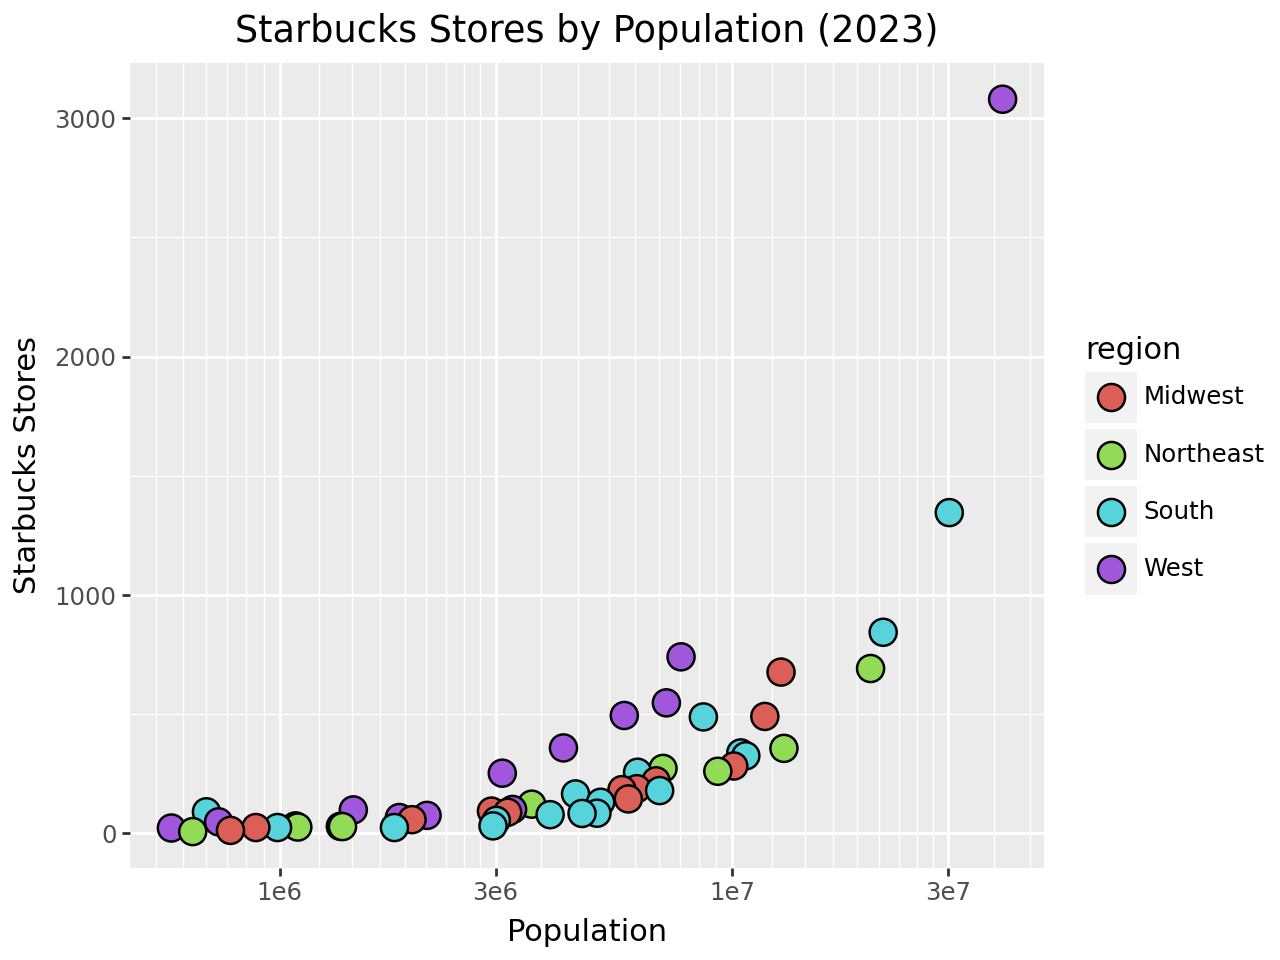

In [242]:
# create a new df that specifies year as 2023
print((ggplot(coffee_2023, aes(x='Population', y='starb_locs', fill='region')) + 
    geom_point(size=5) +
    labs(title="Starbucks Stores by Population (2023)", x="Population", y="Starbucks Stores") +
    scale_x_log10()
))


C:\Users\hblin\AppData\Local\Temp\ipykernel_7756\172717496.py:1: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().
c:\Users\hblin\AppData\Local\Programs\Python\Python312\Lib\site-packages\plotnine\layer.py:364: PlotnineWarning: geom_point : Removed 1 rows containing missing values.


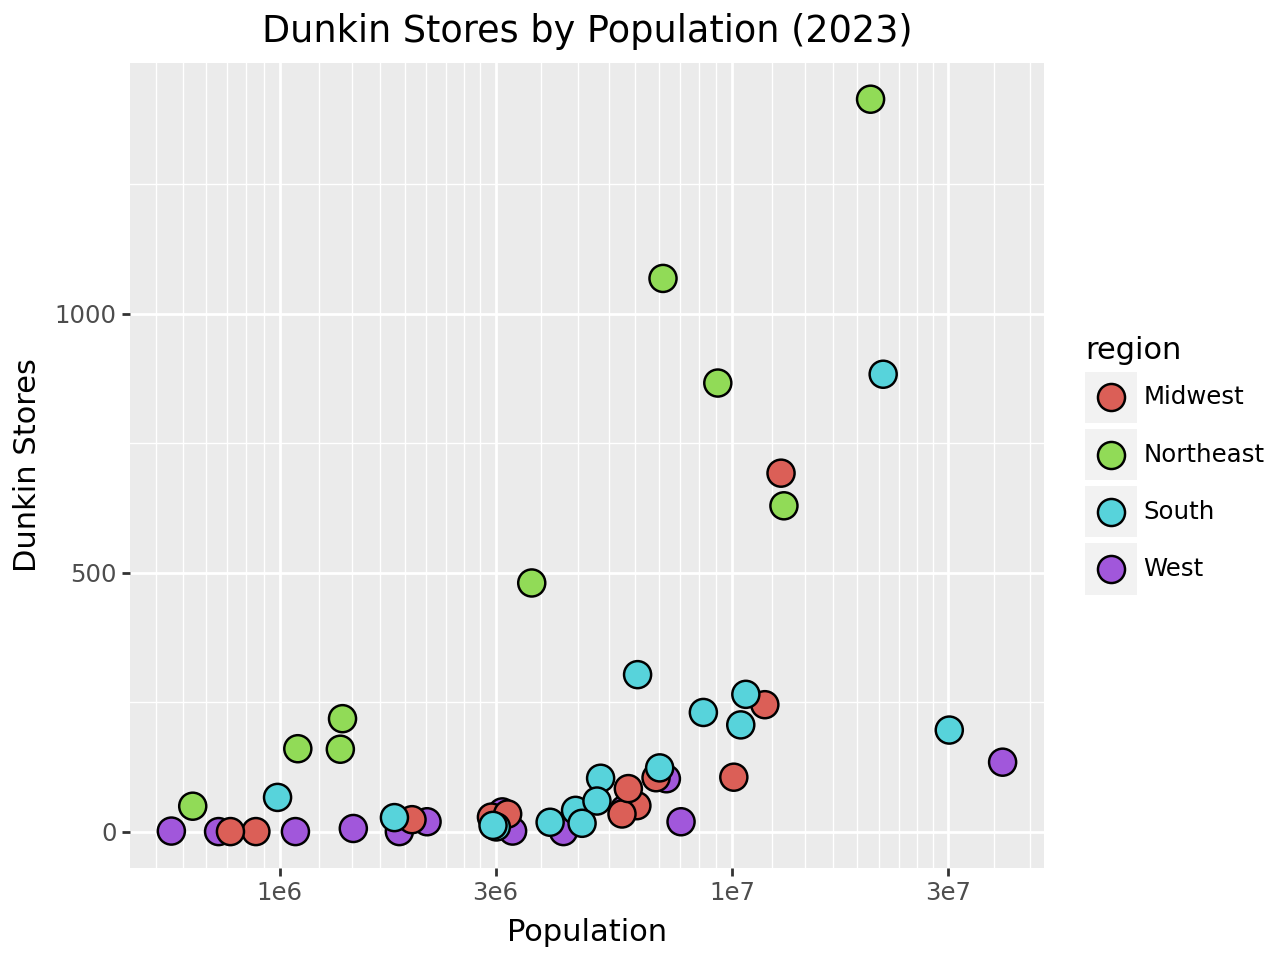

In [241]:
print((ggplot(coffee_2023, aes(x='Population', y='dunkin_locs', fill='region')) + 
    geom_point(size=5) +
    labs(title="Dunkin Stores by Population (2023)", x="Population", y="Dunkin Stores") +
    scale_x_log10()))


## How has Dunkin expanded from 2023 to 2024? 
As we can see in the code below, Dunkin saw an increase in total store locations across all regions. The South saw the largest amount of growth(almost 200 locations), but the South is also the largest region in this dataset. The size of the region could be an explanatory factor, or it could be that Dunkin is trying to shift its prevalence deeper into the South since the Northeast is relatively saturated(Northeast locations only grew by about 15). For a more granular view, the store totals are also grouped by state and year, which shows that both the NE and South are still both growing, but once again the NE seems to have slowed down. 

In [257]:
print(coffee.groupby(['region','Year'])['dunkin_locs'].sum())

region     Year
Midwest    2023    1398.0
           2024    1479.0
Northeast  2023    5043.0
           2024    5060.0
South      2023    2557.0
           2024    2756.0
West       2023     363.0
           2024     371.0
Name: dunkin_locs, dtype: float64


In [266]:
print(coffee.groupby(['state', 'Year'])['dunkin_locs'].sum().sort_values(ascending=False).head(20))

state          Year
New York       2024    1431.0
               2023    1414.0
Massachusetts  2023    1068.0
               2024    1042.0
Florida        2024     909.0
               2023     883.0
New Jersey     2024     872.0
               2023     866.0
Illinois       2024     711.0
               2023     692.0
Pennsylvania   2024     650.0
               2023     629.0
Connecticut    2023     480.0
               2024     476.0
Maryland       2024     311.0
               2023     303.0
Georgia        2024     287.0
               2023     265.0
Ohio           2024     261.0
               2023     245.0
Name: dunkin_locs, dtype: float64


## How has Starbucks expanded from 2023 to 2024?
The first 10 states are the only ones in the dataset that contain values for the 2024 Starbucks locations. However, we do see steady expansion in locations at least for these first 10 states as well. Florida, Texas, and Arizona seem to show the highest amount of growth out of this list, leading to a possible battle for Florida between chains.

In terms of Revenue, Starbucks went from 36B to 36.2B which is a .56% increase, showing they are still growing( I am not sure exactly how good this is in terms of growth for the company but at least it is positive)

In [264]:
print(coffee.groupby(['state', 'Year'])['starb_locs'].sum().sort_values(ascending=False).head(20))


state       Year
California  2024    3117.0
            2023    3080.0
Texas       2024    1409.0
            2023    1346.0
Florida     2024     892.0
            2023     844.0
Washington  2023     741.0
            2024     736.0
New York    2024     715.0
            2023     692.0
Illinois    2024     685.0
            2023     677.0
Arizona     2024     579.0
            2023     548.0
Virginia    2024     510.0
Colorado    2024     506.0
Ohio        2024     499.0
Colorado    2023     495.0
Ohio        2023     491.0
Virginia    2023     489.0
Name: starb_locs, dtype: float64


## Further Exploration:
On account of a lack of data, such 2024 Starbucks locations not being fully updated, the revenue for 2024 Dunkin, as well as no revenue available by state(that I was able to find) a full analysis and comparison of the two chains could not be completed. Some ideas for further analysis with updated data could entail:
- Year over year growth of locations, and the associated revenue for each chain( would love to look at percentage growth in revenue by percentage growth in number of stores)
- Year over year growth of revenue by region/state 
- Comparison of revenue growth by both chains by year 
- Possibly choose a differnet metric with more information by state or year



# Automate

In [230]:

def scrape_data(url):
    # Send a GET request to the URL
    response = requests.get(url)
    soup = BeautifulSoup(response.content, "html.parser")
    
    # Find the company name in the URL
    company_name = re.search(r'(?<=/)[a-z-]+(?=-by-state|-by-country)', url)
    company_name = company_name.group().replace('-', ' ').title() if company_name else 'Company'
    
    # Scrape the table data
    rows = []
    table = soup.find("table")  # Find the first table on the page

    # Check if the table exists
    if table:
        # Extract the headers from the table
        headers = [th.get_text(strip=True) for th in table.find("tr").find_all("th")]

        # Check if "State" or "Country" is part of headers to add to rows
        if "State" not in headers and "Country" not in headers:
            headers.insert(0, "State/Country")  # Add placeholder for state/country

        # Loop through the rows in the table (skipping the header)
        for row in table.find_all("tr")[1:]:
            cells = row.find_all("td")
            
            if cells:  # Ensure the row contains data cells
                row_data = []

                # Extract State/Country name from anchor tag if it exists
                state_country_tag = row.find("th")  # Assuming the first column is state or country
                if state_country_tag and state_country_tag.a:
                    state_country = state_country_tag.a.get_text(strip=True)
                else:
                    state_country = state_country_tag.get_text(strip=True) if state_country_tag else ""

                row_data.append(state_country)  # Append the state/country to the row data

                # Extract cell values
                row_data.extend(cell.get_text(strip=True) for cell in cells)

                # Handle missing columns by filling with None or empty strings
                while len(row_data) < len(headers):
                    row_data.append('')  # Fill missing columns with empty strings
                
                # Create a dictionary for each row, matching headers to row data
                row_dict = dict(zip(headers, row_data))
                rows.append(row_dict)

    else:
        print("Table not found.")

    # Create DataFrame
    locations = pd.DataFrame(rows)
    return locations, company_name

# Usage Example
url_starbs = "https://worldpopulationreview.com/country-rankings/starbucks-stores-by-country"

# Scrape Starbucks locations
starbs_locations, starbs_company_name = scrape_data(url_starbs)
print(starbs_locations.head())




         Country Total # of Stores Company Operated Licensed Stores
0  United States            16,346            9,645           6,701
1          China             6,804            6,804                
2    South Korea             1,870                            1,870
3          Japan             1,733            1,733                
4         Canada             1,458              977             481


Ethics Statement and References: This lab scraped the data from a couple websites on different popular coffee chains. I searched for all the missing values on the internet, and unfortunately came up short on some of them such as the Dunkin donuts revenue data for 2024. As a result, I believe a complete analysis of the data was not fully possible, and made the best of what I had and what I could come up with. Additionally, Generative AI was used to assist with some of the automation/scraping methods since I was not sure how I would do that in a complete package. 

Starbucks Revenue: https://investor.starbucks.com/news/financial-releases/news-details/2024/Starbucks-Reports-Preliminary-Q4-and-Full-Fiscal-Year-2024-Results/default.aspx#:~:text=For%20the%20full%20fiscal%20year,down%208%25%20over%20prior%20year. 

Dunkin Donuts Revenue: https://www.zippia.com/dunkin-donuts-careers-554008/revenue/ 